# Ridge training in primal form

The primal form of the dynamics is

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{f}_{base}(\mathbf{x}) + B\mathbf{u} + CW^T\boldsymbol{\psi}(\mathbf{x})$$

Define the Loss function as the error between the true and target velocity fields given a set of locations and inputs:

$$\mathcal{L}(W; \{(\mathbf{v}, \mathbf{x}, \mathbf{u})^i\}) \equiv \sum_i \| \mathbf{v}^i - \frac{d\mathbf{x}}{dt}\left(\mathbf{x}^i, \mathbf{u}^i; W \right)\|^2$$

where $\mathbf{F} \equiv \frac{d\mathbf{x}}{dt}.$

For a fixed set of $\mathbf{x}^*$ this can be formulated as a linear regression problem in $\boldsymbol{\alpha}$. For simplicity let $C = I$. Then the component $d$ of the flow field is given via

$$\tau v_d^i = -x_d^i + f_d^{base}(\mathbf{x}^i) + (B\mathbf{u}^i)_d + \mathbf{w}_d^T\boldsymbol{\psi(x)}$$

i.e.

$$y_d^i \equiv \tau v_d^i + x_d^i - f_d^{base}(\mathbf{x}^i) - (B\mathbf{u}^i)_d = \mathbf{w}_d^T\boldsymbol{\psi(x)}
$$

where $\mathbf{w}_d$ is the d-th column of $W$.

Thus, letting 

$$\mathbf{y}_d \equiv [y_d^1, \dots y_d^N]^T \quad
\text{and} \quad \Psi \equiv
\begin{bmatrix}
\boldsymbol{\psi}(\mathbf{x}_1), 
\dots ,
\boldsymbol{\psi}(\mathbf{x}_N)
\end{bmatrix}^T
$$

we can write

$$\mathbf{y}_d^T = \mathbf{w}_d^T\Psi^T$$

or

$$\Psi \mathbf{w}_d = \mathbf{y}_d$$

which we can solve using e.g. Ridge regression.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge

import jax
import jax.numpy as jnp
from jax import grad, vmap, random

from aux import get_flow
from aux_j import run_fwd_jnp
from kernels_jax import make_psi_rand_tanh_k_wta, make_psi_rand_sgm, make_psi_rand_lin
from disp import set_plot, colors, quiver

print('JAX', jax.__version__, jax.devices())

JAX 0.4.30 [CpuDevice(id=0)]


In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 13)

t_test = np.arange(0, .3, .001)
x_inits = .5*np.random.randn(20, 2)  # test initial conditions

# base system params
TAU = jnp.array(.01)
B = jnp.eye(D)
f_base = lambda x: jnp.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

# control directions
C = jnp.array([
    [1., 0],
    [0,  1],
])  #L   U

# psi
N = 2000
K = 50
G = 1
J_PSI = G*np.random.randn(N, D)
# psi, ker = make_psi_rand_tanh_k_wta(J_PSI, K)
psi, ker = make_psi_rand_sgm(J_PSI)
# psi, ker = make_psi_rand_lin(J_PSI)

In [3]:
def eval_F(x, u, W):
    
    df = C@W.T@psi(x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)


def smlt_trj(W, x_init, t):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], np.zeros(D), W)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

In [4]:
def plot_quivers(W, u=None, arrow_scale=.5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, W)
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, W)
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{learned}$')

    quiver(axs[3], flow_post-flow_base, RX)
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs
    
def plot_trjs(W, x_inits, t):
    fig, axs = plt.subplots(1, len(x_inits), figsize=(len(x_inits)*3, 2), tight_layout=True, squeeze=False)
    axs = axs[0, :]
    
    xs_all = []
    
    for ax, x_init in zip(axs, x_inits):
        xs = run_fwd_jnp(lambda x, u: eval_F(x, u, W), x_init, t)
        xs_all.append(xs)
        
        ax.plot(t, xs)
        set_plot(ax, y_lim=(-1.5, 1.5), x_label='Time (s)', y_label='x')
        
    return xs_all

In [5]:
def train(data, lam=1e-8):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = jnp.array([f_base(x) for x in xs])
    Bus = jnp.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make Psi
    Psi = jnp.array([psi(x) for x in xs])
    
    # find best alphas
    rgr = Ridge(alpha=lam, fit_intercept=False)
    W = rgr.fit(Psi, ys).coef_.T
    return W

## One fixed point

In [6]:
thetas = [0.]
xs = jnp.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = jnp.array([0. ,0])
vs = jnp.tile(v, (len(xs), 1))
u = jnp.array([0., 0])
us = jnp.tile(u, (len(xs), 1))

data = jnp.concatenate([xs, vs, us], axis=1)
lam = 1e-8

W = train(data, lam)

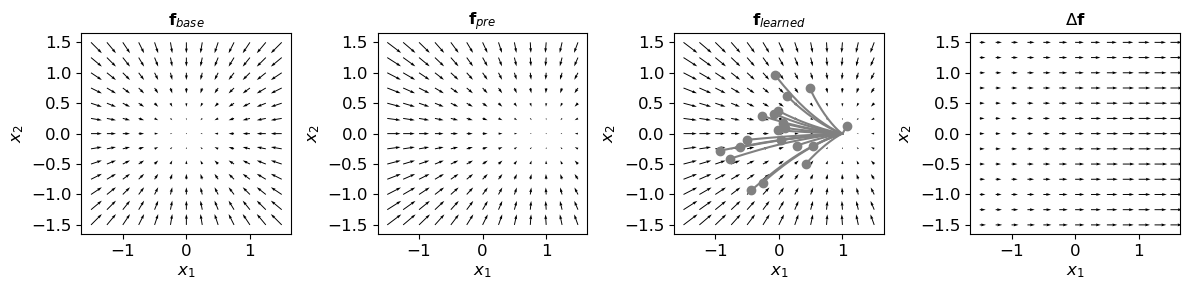

In [7]:
# plot flow fields
fig, axs = plot_quivers(W, arrow_scale=0, u=None)
for x_init in x_inits:
    xs_test = smlt_trj(W, x_init, t_test)
    axs[2].plot(*xs_test.T, c='gray')
    axs[2].scatter(*xs_test[0, :], c='gray')

## Two fixed points

In [8]:
thetas = [0., np.pi]
xs = jnp.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = jnp.array([0. ,0])
vs = jnp.tile(v, (len(xs), 1))
u = jnp.array([0., 0])
us = jnp.tile(u, (len(xs), 1))

data = jnp.concatenate([xs, vs, us], axis=1)
lam = 1e-5

W = train(data, lam)

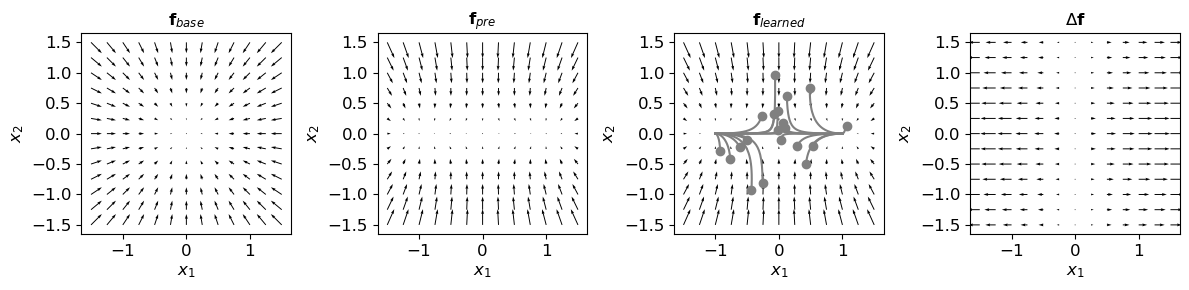

In [9]:
# plot flow fields
fig, axs = plot_quivers(W, arrow_scale=0, u=None)
for x_init in x_inits:
    xs_test = smlt_trj(W, x_init, t_test)
    axs[2].plot(*xs_test.T, c='gray')
    axs[2].scatter(*xs_test[0, :], c='gray')

## Three fixed points

In [10]:
thetas = [0., 2*np.pi/3, 4*np.pi/3]
xs = jnp.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = jnp.array([0. ,0])
vs = jnp.tile(v, (len(xs), 1))
u = jnp.array([0., 0])
us = jnp.tile(u, (len(xs), 1))

data = jnp.concatenate([xs, vs, us], axis=1)
lam = 1e-5

W = train(data, lam)

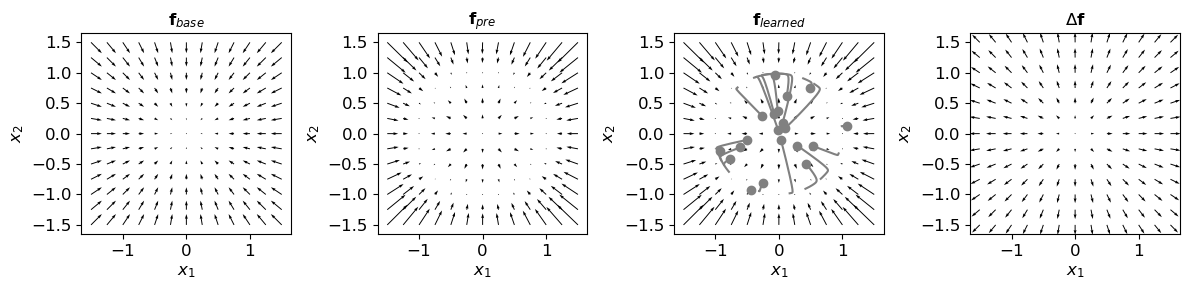

In [11]:
# plot flow fields
fig, axs = plot_quivers(W, arrow_scale=0, u=None)
for x_init in x_inits:
    xs_test = smlt_trj(W, x_init, t_test)
    axs[2].plot(*xs_test.T, c='gray')
    axs[2].scatter(*xs_test[0, :], c='gray')